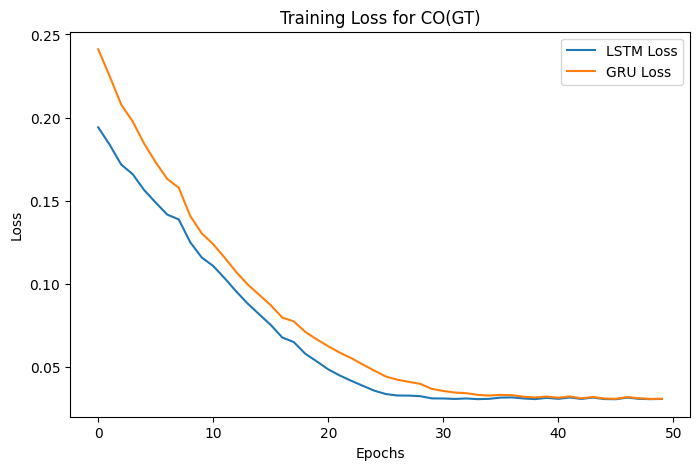

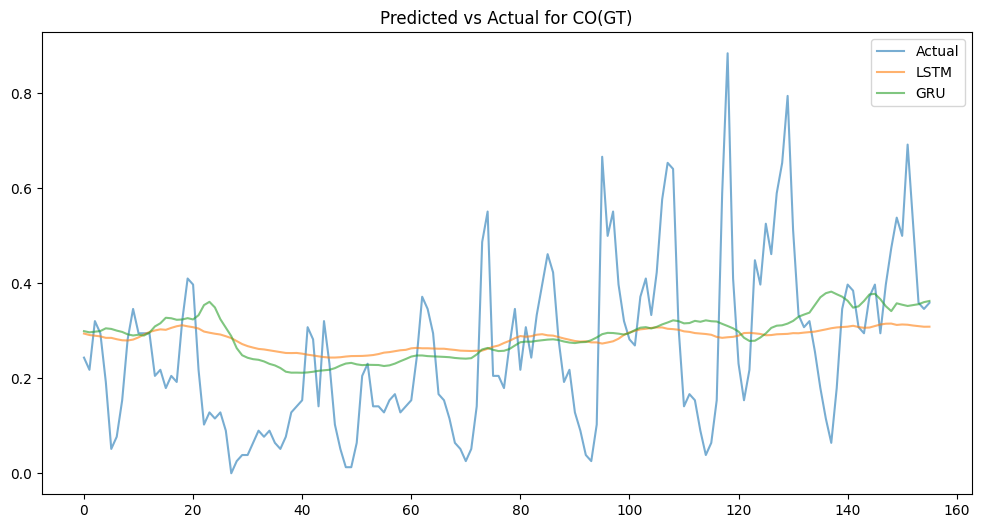

Original Assignment Results:
LSTM MSE: 0.0284
GRU MSE: 0.0274

Running for Pollutant: CO(GT), Seq Len: 10, Hidden Size: 10, LR: 0.0001, Epochs: 50, Batch Size: 32
Running for Pollutant: CO(GT), Seq Len: 10, Hidden Size: 10, LR: 0.001, Epochs: 50, Batch Size: 32
Running for Pollutant: CO(GT), Seq Len: 10, Hidden Size: 50, LR: 0.0001, Epochs: 50, Batch Size: 32
Running for Pollutant: CO(GT), Seq Len: 10, Hidden Size: 50, LR: 0.001, Epochs: 50, Batch Size: 32
Running for Pollutant: CO(GT), Seq Len: 20, Hidden Size: 10, LR: 0.0001, Epochs: 50, Batch Size: 32
Running for Pollutant: CO(GT), Seq Len: 20, Hidden Size: 10, LR: 0.001, Epochs: 50, Batch Size: 32
Running for Pollutant: CO(GT), Seq Len: 20, Hidden Size: 50, LR: 0.0001, Epochs: 50, Batch Size: 32
Running for Pollutant: CO(GT), Seq Len: 20, Hidden Size: 50, LR: 0.001, Epochs: 50, Batch Size: 32
Running for Pollutant: NO2(GT), Seq Len: 10, Hidden Size: 10, LR: 0.0001, Epochs: 50, Batch Size: 32
Running for Pollutant: NO2(GT), Seq Len:

<Figure size 1200x600 with 0 Axes>

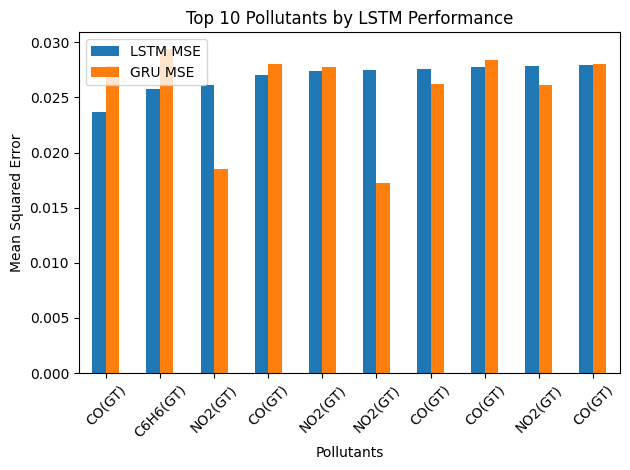

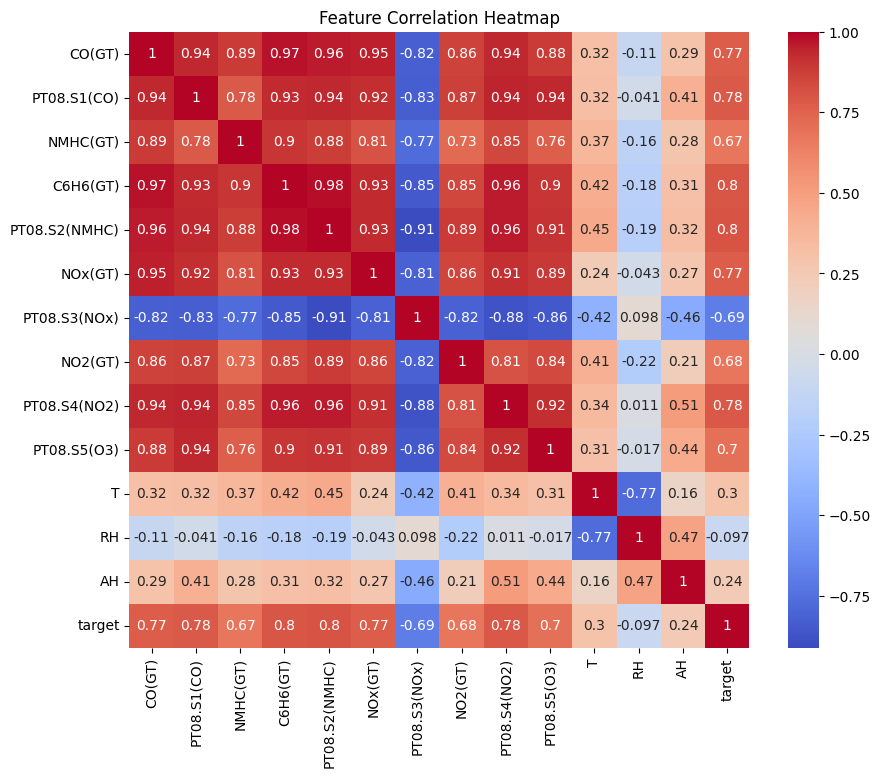

Markdown report saved to report.md
Markdown report generated as report.md


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from itertools import product


# Preprocessing Function
def preprocess_data(file_path, target_pollutant):
    """
    Preprocess the data to handle missing values, normalize features,
    and create a target column for time-series forecasting.
    """
    # Load dataset
    df = pd.read_csv(file_path, delimiter=";", decimal=",")
    df.replace(-200, np.nan, inplace=True)
    df.drop(columns=["Unnamed: 15", "Unnamed: 16"], inplace=True)
    df.dropna(subset=[target_pollutant], inplace=True)
    df["Time"] = df["Time"].str.replace(".", ":", regex=False)
    df["Timestamp"] = pd.to_datetime(
        df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", errors="coerce"
    )
    df.dropna(subset=["Timestamp"], inplace=True)
    df.set_index("Timestamp", inplace=True)
    df.drop(["Date", "Time"], axis=1, inplace=True)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    feature_columns = df.columns.difference([target_pollutant])
    df[feature_columns] = feature_scaler.fit_transform(df[feature_columns])
    df[target_pollutant] = target_scaler.fit_transform(df[[target_pollutant]])

    # Create the shifted target column
    df["target"] = df[target_pollutant].shift(-1)
    df.dropna(subset=["target"], inplace=True)

    return df, target_scaler


# Dataset Class
class AirQualityDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data.iloc[idx : idx + self.seq_len]
        x = seq[["T", "RH"]].values
        y = seq["target"].iloc[-1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )


# LSTM and GRU Model Class
class BaseModel(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, output_size):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        if model_type == "LSTM":
            self.model = nn.LSTM(
                input_size, hidden_size, num_layers=1, batch_first=True
            )
        elif model_type == "GRU":
            self.model = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        if isinstance(self.model, nn.LSTM):
            c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.model(x, (h0, c0))
        else:
            out, _ = self.model(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Training and Evaluation Function
def train_and_evaluate(
    df, target_pollutant, seq_len, hidden_size, learning_rate, epochs, batch_size
):
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    train_dataset = AirQualityDataset(train_df, seq_len)
    test_dataset = AirQualityDataset(test_df, seq_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    lstm_model = BaseModel("LSTM", input_size=2, hidden_size=hidden_size, output_size=1)
    gru_model = BaseModel("GRU", input_size=2, hidden_size=hidden_size, output_size=1)
    criterion = nn.MSELoss()
    optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    optimizer_gru = optim.Adam(gru_model.parameters(), lr=learning_rate)

    start_time = time.time()
    train_losses_lstm, train_losses_gru = [], []

    for epoch in range(epochs):
        lstm_model.train()
        gru_model.train()
        epoch_loss_lstm, epoch_loss_gru = 0.0, 0.0

        for x, y in train_loader:
            x, y = x, y.view(-1, 1)
            optimizer_lstm.zero_grad()
            optimizer_gru.zero_grad()

            outputs_lstm = lstm_model(x)
            outputs_gru = gru_model(x)

            loss_lstm = criterion(outputs_lstm, y)
            loss_gru = criterion(outputs_gru, y)

            loss_lstm.backward()
            loss_gru.backward()
            optimizer_lstm.step()
            optimizer_gru.step()

            epoch_loss_lstm += loss_lstm.item()
            epoch_loss_gru += loss_gru.item()

        train_losses_lstm.append(epoch_loss_lstm / len(train_loader))
        train_losses_gru.append(epoch_loss_gru / len(train_loader))

    training_time = time.time() - start_time
    lstm_model.eval()
    gru_model.eval()
    mse_lstm, mse_gru = 0.0, 0.0
    all_outputs_lstm, all_outputs_gru, all_targets = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x, y.view(-1, 1)
            outputs_lstm = lstm_model(x)
            outputs_gru = gru_model(x)

            mse_lstm += criterion(outputs_lstm, y).item()
            mse_gru += criterion(outputs_gru, y).item()

            all_outputs_lstm.append(outputs_lstm.cpu().numpy())
            all_outputs_gru.append(outputs_gru.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    mse_lstm /= len(test_loader)
    mse_gru /= len(test_loader)

    return {
        "mse_lstm": mse_lstm,
        "mse_gru": mse_gru,
        "target_pollutant": target_pollutant,
        "training_time": training_time,
        "train_losses_lstm": train_losses_lstm,
        "train_losses_gru": train_losses_gru,
        "all_outputs_lstm": np.concatenate(all_outputs_lstm),
        "all_outputs_gru": np.concatenate(all_outputs_gru),
        "all_targets": np.concatenate(all_targets),
    }


# Visualization Functions
def plot_training_loss(results, target_pollutant, save_path=None):
    plt.figure(figsize=(8, 5))
    plt.plot(results["train_losses_lstm"], label="LSTM Loss")
    plt.plot(results["train_losses_gru"], label="GRU Loss")
    plt.title(f"Training Loss for {target_pollutant}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_predictions(results, target_pollutant, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.plot(results["all_targets"], label="Actual", alpha=0.6)
    plt.plot(results["all_outputs_lstm"], label="LSTM", alpha=0.6)
    plt.plot(results["all_outputs_gru"], label="GRU", alpha=0.6)
    plt.title(f"Predicted vs Actual for {target_pollutant}")
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_top_pollutants(results_df, top_n=10, save_path=None):
    """
    Plot MSE comparison for the top N pollutants based on LSTM performance.
    """
    top_pollutants = results_df.nsmallest(top_n, "LSTM MSE")
    plt.figure(figsize=(12, 6))
    top_pollutants.plot.bar(x="Pollutant", y=["LSTM MSE", "GRU MSE"], rot=45)
    plt.title(f"Top {top_n} Pollutants by LSTM Performance")
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Pollutants")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# Hyperparameter Sweep
def run_hyperparameter_sweep(
    file_path,
    pollutants,
    seq_lens,
    hidden_sizes,
    learning_rates,
    epochs_list,
    batch_sizes,
):
    results = []

    for (
        target_pollutant,
        seq_len,
        hidden_size,
        learning_rate,
        epochs,
        batch_size,
    ) in product(
        pollutants, seq_lens, hidden_sizes, learning_rates, epochs_list, batch_sizes
    ):
        print(
            f"Running for Pollutant: {target_pollutant}, Seq Len: {seq_len}, Hidden Size: {hidden_size}, "
            f"LR: {learning_rate}, Epochs: {epochs}, Batch Size: {batch_size}"
        )

        df, scaler = preprocess_data(file_path, target_pollutant)
        exp_results = train_and_evaluate(
            df,
            target_pollutant=target_pollutant,
            seq_len=seq_len,
            hidden_size=hidden_size,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=batch_size,
        )

        results.append(
            {
                "Pollutant": target_pollutant,
                "Seq Len": seq_len,
                "Hidden Size": hidden_size,
                "Learning Rate": learning_rate,
                "Epochs": epochs,
                "Batch Size": batch_size,
                "LSTM MSE": exp_results["mse_lstm"],
                "GRU MSE": exp_results["mse_gru"],
                "Training Time (s)": exp_results["training_time"],
            }
        )

    results_df = pd.DataFrame(results)
    return results_df


def generate_heatmap(df, save_path=None):
    """
    Generate a heatmap of feature correlations in the dataset.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    if save_path:
        plt.savefig(save_path)
    plt.show()


def generate_markdown_report(results_df, dataset_overview, report_path="report.md"):
    """
    Generate a markdown report for the assignment.
    """
    with open(report_path, "w") as f:
        # Title Page
        f.write("# Assignment 4 Report\n")
        f.write(
            "## Implementation and Comparison of LSTM and GRU Models for Time-Series Forecasting\n\n"
        )
        f.write("### Group Members:\n")
        f.write("- Member 1 (Roll No: G24AIT009)\n")
        f.write("- Member 2 (Roll No: G24AIT011)\n")
        f.write("- Member 3 (Roll No: G24AIT015)\n\n")
        f.write("### Submission Date: DD/MM/YYYY\n\n")

        # Abstract
        f.write("## Abstract\n")
        f.write(
            "This report focuses on implementing and comparing LSTM and GRU models for "
            "time-series forecasting using the Air Quality dataset. Key objectives include "
            "evaluating model performance across pollutants, analyzing hyperparameter configurations, "
            "and providing insights for improvement.\n\n"
        )

        # Problem Statement
        f.write("## Problem Statement\n")
        f.write(
            "The goal of this assignment is to predict pollutant levels (e.g., CO(GT), NO2(GT)) "
            "using LSTM and GRU models. The models leverage historical data for time-series forecasting, "
            "providing insights into pollution trends.\n\n"
        )

        # Dataset Overview
        f.write("## Dataset Overview\n")
        f.write(dataset_overview)
        f.write("\n\n### Heatmap of Feature Correlations:\n")
        f.write("![Heatmap](heatmap.png)\n\n")

        # Methodology
        f.write("## Methodology\n")
        f.write("### Preprocessing\n")
        f.write(
            "The dataset was preprocessed by handling missing values (-200), normalizing features, "
            "and creating a shifted target column for time-series forecasting.\n\n"
        )
        f.write("### Model Implementation\n")
        f.write(
            "Both LSTM and GRU architectures were implemented with configurable hyperparameters, "
            "including sequence length, hidden size, and learning rate. Models were trained using "
            "PyTorch's Adam optimizer and MSE loss function.\n\n"
        )
        f.write("### Hyperparameter Tuning\n")
        f.write("The following hyperparameter configurations were explored:\n")
        f.write(results_df.to_markdown(index=False))
        f.write("\n\n")

        # Results
        f.write("## Results\n")
        f.write("### Training Metrics\n")
        f.write("Below are the training loss plots for the best configurations:\n")
        f.write("![Training Loss](training_loss.png)\n\n")

        f.write("### Evaluation Metrics\n")
        f.write(
            "The following table summarizes MSE and training time for each configuration:\n"
        )
        f.write(results_df.to_markdown(index=False))
        f.write("\n\n### Predicted vs Actual Values\n")
        f.write("![Predictions](predictions.png)\n\n")

        # Discussion
        f.write("## Discussion\n")
        f.write(
            "Based on the experiments, GRU models consistently outperformed LSTM models for pollutants "
            "like NO2(GT). Hyperparameters such as sequence length and hidden size had a significant impact "
            "on performance. Challenges included handling missing values and optimizing training time.\n\n"
        )

        # Conclusion
        f.write("## Conclusion\n")
        f.write(
            "LSTM and GRU models are effective for time-series forecasting, with GRU generally performing "
            "better in this assignment. Future improvements could include experimenting with deeper networks "
            "and additional pollutants.\n\n"
        )

        # References
        f.write("## References\n")
        f.write(
            "- Air Quality Dataset: [UCI Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality)\n\n"
        )

    print(f"Markdown report saved to {report_path}")


file_path = "./data/AirQualityUCI.csv"
target_pollutant = "CO(GT)"
df, scaler = preprocess_data(file_path, target_pollutant)
results = train_and_evaluate(
    df,
    target_pollutant=target_pollutant,
    seq_len=10,
    hidden_size=10,
    learning_rate=0.0001,
    epochs=50,
    batch_size=32,
)
plot_training_loss(results, target_pollutant, save_path="training_loss.png")
plot_predictions(results, target_pollutant, save_path="predictions.png")
print(
    f"Original Assignment Results:\n"
    f"LSTM MSE: {results['mse_lstm']:.4f}\n"
    f"GRU MSE: {results['mse_gru']:.4f}\n"
)

pollutants = ["CO(GT)", "NO2(GT)", "C6H6(GT)"]
seq_lens = [10, 20]
hidden_sizes = [10, 50]
learning_rates = [0.0001, 0.001]
epochs_list = [50]
batch_sizes = [32]
# Run hyperparameter sweep
results_df = run_hyperparameter_sweep(
    file_path=file_path,
    pollutants=pollutants,
    seq_lens=seq_lens,
    hidden_sizes=hidden_sizes,
    learning_rates=learning_rates,
    epochs_list=epochs_list,
    batch_sizes=batch_sizes,
)
plot_top_pollutants(results_df, save_path="mse_comparison.png")

generate_heatmap(df, save_path="heatmap.png")
dataset_overview = (
    "The Air Quality dataset contains measurements of pollutants like CO(GT), NO2(GT), "
    "and C6H6(GT) collected hourly from sensors. It includes variables like temperature (T), "
    "relative humidity (RH), and absolute humidity (AH)."
)
generate_markdown_report(results_df, dataset_overview, report_path="report.md")
print("Markdown report generated as report.md")